# GAN Assignment

## Student Name : Devesh Surve

Take the code attached and then change the generator and the discriminator architectures by introducing convolution layers. Use one of the classes from the CIFAR-10 dataset to generate images. Show the effect of controlling the noise vector. Prepare a few slides and submit along with your notebook code. You may be asked to present the slides in the class.

# Theory on GANs

GANs are a class of Unsupervised Learning Algorithms that do much more than just recognizing image / voice , predicting or translating. They implement deep neural networks or CNN and are comprised of two parts, pitting one against the other (thus the “adversarial”).

### These two parts are called the Generator and the Discriminator.

## Generator

The generator takes the role of a forger and tries to create music/image/speech from random noise. It learns to map from a latent space to a particular data distribution of interest. It generally implements a Deconvolutional Network to do so.

## Discriminator

The Discriminator on the other hand takes the role of the evaluater and tries to distinguish the fake data (created by the Generator) from the real one. It is usually implemented as a Convolutional Network.



# Importing the Required Libraries

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam


#### Note : The Professor's code is in a class based structure. So temporarily we break it down to understand and modify

Later once we have our final values, we reconstruct it back.

### First, we change the dataset being used from MNIST to CIFAR-10

In [46]:
# Load CIFAR10 data
(X_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select a single class images (Cars)
X_train = X_train[y_train.flatten() == 1]

170498071/170498071 [==============================] - 2s 0us/step


### Here are the images we are trying to generate

We use the class 1, which is the cars/automobiles class.

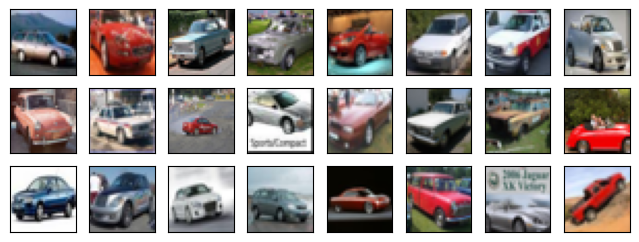

In [62]:
plt.figure(figsize=(8, 8))
for i in range(24):
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
plt.show()


### Next, we change the input shape to 32 X 32 from 28 X 28 as defined earlier

In [47]:
# Input shape
img_rows = 32
img_cols = 32
channels = 3

img_shape = (img_rows, img_cols, channels)
noise_shape = 100

## **The Generator**


To learn a generator distribution p<sub>g</sub> over data x,the generator builds a mapping function from a prior noise distribution p<sub>z</sub>(z) to data space as G(z). The discriminator outputs, a single scalar representing the probability that x came from training data rather than p<sub>g</sub>.

G and D are both trained simultaneously: we adjust parameters for G to minimize log(1 - D(G(z)) and adjust parameters for D to minimize logD(x), as if they are following the two-player min-max game with value function V (G;D):

![](https://github.com/Ibtastic/Generative-Adversarial-Networks/raw/master/GAN/loss.png)

## Modifying the Generator

Here's our original generator.

Upon studying more on the topic. We make the following improvements.

- Convolutional Layers: By introducing Conv2DTranspose layers, the network can better learn and generate spatial features, enhancing the realism of generated images.Transposed convolution layer (sometimes called Deconvolution).
- UpSampling2D: In the generator we use a method called  [Upsampling](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) ( Here's a great article on it ) to produce images. These layers increase the spatial dimensions of the feature maps, allowing the network to transform a dense representation into a full-resolution image.
- Activation Adjustments: The final Activation layer uses tanh to ensure the output pixel values are normalized between -1 and 1, aligning with the preprocessed input data distribution.


In [ ]:
''' Here's professor's old code.
'''

# def build_generator():

#   model.add(Dense(256, input_shape=noise_shape))
#   model.add(LeakyReLU(alpha=0.2))
#   model.add(BatchNormalization(momentum=0.8))
#   model.add(Dense(512))
#   model.add(LeakyReLU(alpha=0.2))
#   model.add(BatchNormalization(momentum=0.8))
#   model.add(Dense(1024))
#   model.add(LeakyReLU(alpha=0.2))
#   model.add(BatchNormalization(momentum=0.8))
#   model.add(Dense(np.prod(self.img_shape), activation='tanh'))
#   model.add(Reshape(self.img_shape))

#   model.summary()

#   noise = Input(shape=noise_shape)
#   img = model(noise)

  # return Model(noise, img)


def build_generator(self):
    model = Sequential()

    model.add(Dense(128 * 8 * 8, activation="relu", input_shape=(self.latent_dim,)))
    model.add(Reshape((8, 8, 128)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(128, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(64, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(self.channels, kernel_size=3, padding="same", activation='tanh'))

    model.summary()

    noise = Input(shape=(self.latent_dim,))
    img = model(noise)

    return Model(noise, img)


## **The Discriminator**

The discriminator is also a  CNN  with leaky ReLU activations. Many activation functions will work fine with this basic GAN architecture. However, leaky ReLUs are very popular because they help the gradients flow easier through the architecture.

A regular ReLU function works by truncating negative values to 0. This has the effect of blocking the gradients to flow through the network. Instead of the function being zero, leaky ReLUs allow a small negative value to pass through. That is, the function computes the greatest value between the features and a small factor.
Leaky ReLUs represent an attempt to solve the dying ReLU problem. This situation occurs when the neurons get stuck in a state in which ReLU units always output 0s for all inputs. For these cases, the gradients are completely shut to flow back through the network.

> *This is especially important for GANs since the only way the generator has to learn is by receiving the gradients from the discriminator.*

Finally, the discriminator needs to output probabilities. We use a Sigmoid Activation for that.

In [ ]:
''' Here's professor's old code.
'''
#     def build_discriminator(self):

#         img_shape = (self.img_rows, self.img_cols, self.channels)

#         model = Sequential()

#         model.add(Flatten(input_shape=img_shape))
#         model.add(Dense(512))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dense(256))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dense(1, activation='sigmoid'))
#         model.summary()

#         img = Input(shape=img_shape)
#         validity = model(img)

#         return Model(img, validity)


def build_discriminator(self):
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    img = Input(shape=self.img_shape)
    validity = model(img)

    return Model(img, validity)


Key Improvements:
- Convolutional Layers: The introduction of Conv2D layers enables the discriminator to perform feature extraction directly from the image matrix, maintaining the spatial relationships between pixels.
- Strided Convolutions: By applying strides in the convolutional layers, the network reduces the dimensionality of the feature maps, effectively downsampling the image while extracting relevant features.
- Dropout: Incorporation of Dropout layers aids in combating overfitting by randomly dropping units from the feature maps, adding regularization to the network.
- ZeroPadding: The use of ZeroPadding2D ensures that the boundary information is not lost during convolution operations, preserving the feature dimensions.


## Finally, the training code

I did not make a lot of changes from professors code. 


### Combining the code into a class-based structured as shown in the professor's notebook. 

Changing the save plot function to add ability to plot the graph so as to get a better idea on how the generated images are getting better over time. 

In [2]:
g_loss_list = []
d_loss_list = []

class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model, we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model (stacked generator and discriminator)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    def build_generator(self):
        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_shape=(self.latent_dim,)))
        model.add(Reshape((8, 8, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2DTranspose(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2DTranspose(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2DTranspose(self.channels, kernel_size=3, padding="same", activation='tanh'))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        # Load the dataset
        (X_train, y_train), (_, _) = cifar10.load_data()

        # Filter for Cars (class 1)
        X_train = X_train[y_train.flatten() == 1]

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        half_batch = int(batch_size / 2)
        
        from tqdm import tqdm
        for epoch in tqdm(range(epochs)):

            # ---------------------
            #  Train Discriminator
            # ---------------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.latent_dim))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise, verbose=0)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)            
            g_loss_list.append((epoch, g_loss))
            d_loss_list.append((epoch, d_loss))

            # If at save interval =a> plot generated image samples
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.plot_images(epoch)

    def plot_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        fig.savefig(f"Car_Image_Epoch{epoch}")
        plt.close()

## Running the final code

Note : This cell block takes a while ( Approx 1-1.5 hours with GPU ). Hence, in the zip file I have attached the model'trained H5 files alongside code to execute them to get the image output.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 zero_padding2d (ZeroPaddin  (None, 9, 9, 128)         0         
 g2D)                                                            
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 9, 9, 128)         0         
                                                        

  0%|          | 0/30000 [00:00<?, ?it/s]2024-02-06 17:21:33.176969: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707240095.267663     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0 [D loss: 0.676593, acc.: 43.75%] [G loss: 0.572939]
1/1 [==============================] - 0s 277ms/step


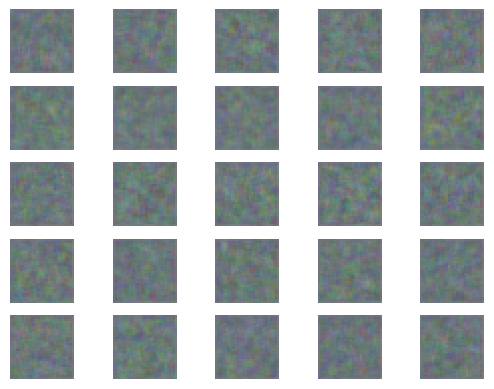

  2%|▏         | 500/30000 [00:58<47:19, 10.39it/s]  

500 [D loss: 0.699872, acc.: 56.25%] [G loss: 0.705947]
1/1 [==============================] - 0s 18ms/step


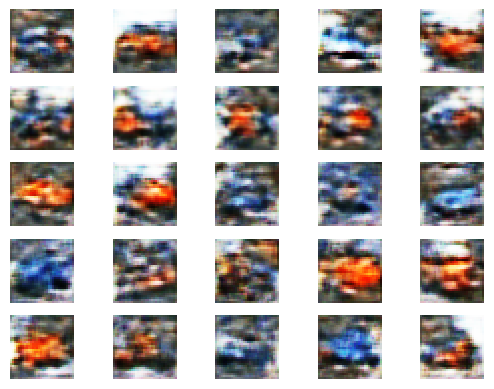

  3%|▎         | 1000/30000 [01:47<46:22, 10.42it/s] 

1000 [D loss: 0.681329, acc.: 56.25%] [G loss: 0.765458]
1/1 [==============================] - 0s 18ms/step


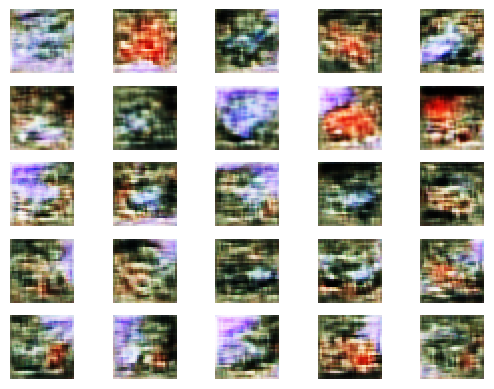

  5%|▌         | 1500/30000 [02:37<45:38, 10.41it/s]  

1500 [D loss: 0.681112, acc.: 65.62%] [G loss: 0.716818]
1/1 [==============================] - 0s 18ms/step


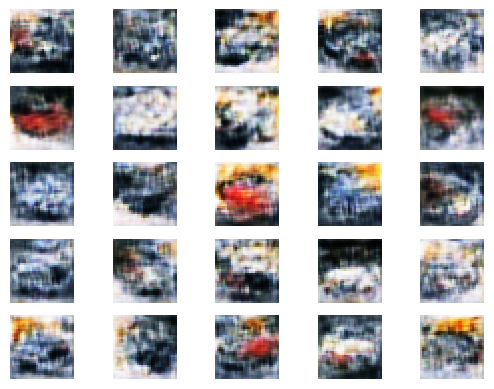

  7%|▋         | 1999/30000 [03:27<43:54, 10.63it/s]  

2000 [D loss: 0.742280, acc.: 17.19%] [G loss: 0.643544]
1/1 [==============================] - 0s 18ms/step


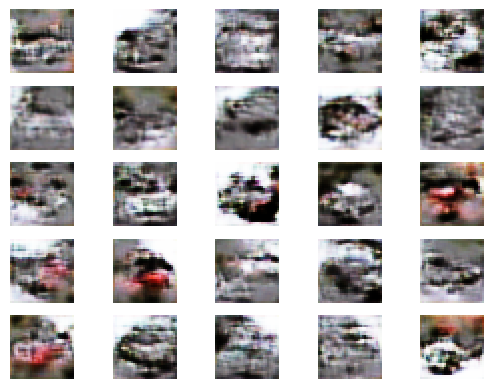

  8%|▊         | 2500/30000 [04:17<46:56,  9.77it/s]  

2500 [D loss: 0.693208, acc.: 51.56%] [G loss: 0.722197]
1/1 [==============================] - 0s 19ms/step


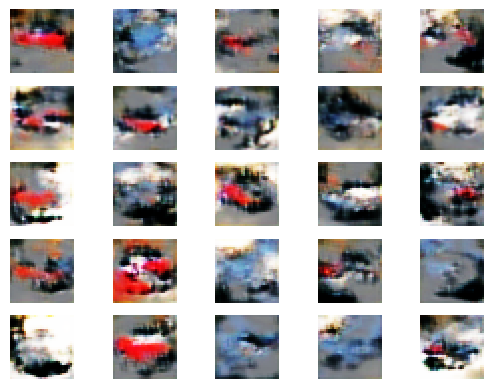

 10%|▉         | 2999/30000 [05:07<44:24, 10.13it/s]  

3000 [D loss: 0.693882, acc.: 46.88%] [G loss: 0.691334]
1/1 [==============================] - 0s 18ms/step


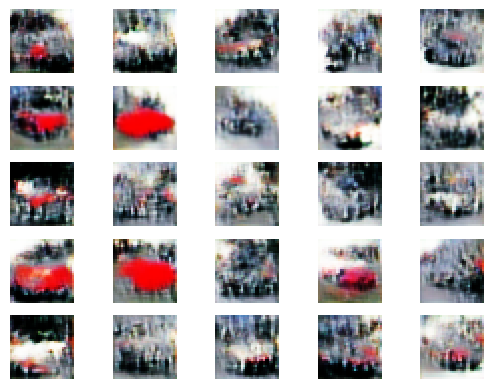

 12%|█▏        | 3500/30000 [05:57<42:48, 10.32it/s]  

3500 [D loss: 0.685367, acc.: 53.12%] [G loss: 0.705562]
1/1 [==============================] - 0s 18ms/step


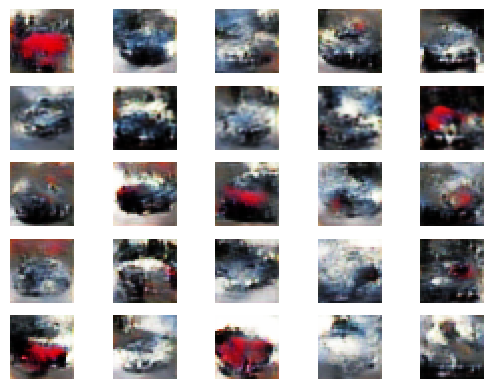

 13%|█▎        | 3999/30000 [06:47<41:36, 10.42it/s]  

4000 [D loss: 0.703526, acc.: 39.06%] [G loss: 0.697142]
1/1 [==============================] - 0s 18ms/step


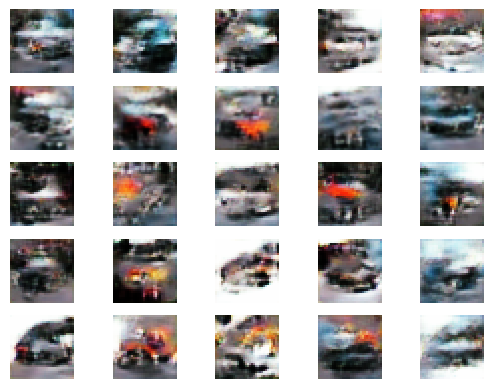

 15%|█▍        | 4499/30000 [07:38<41:21, 10.27it/s]  

4500 [D loss: 0.721544, acc.: 32.81%] [G loss: 0.676271]
1/1 [==============================] - 0s 18ms/step


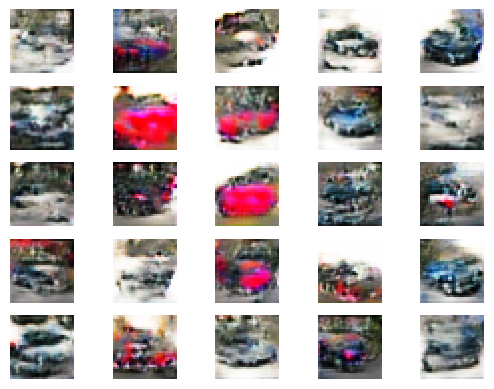

 17%|█▋        | 5000/30000 [08:29<41:06, 10.14it/s]  

5000 [D loss: 0.708686, acc.: 39.06%] [G loss: 0.700763]
1/1 [==============================] - 0s 18ms/step


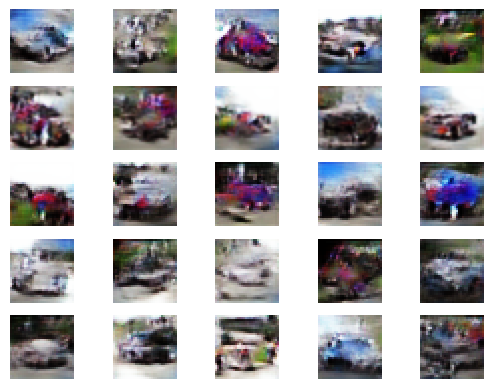

 18%|█▊        | 5500/30000 [09:19<42:22,  9.63it/s]  

5500 [D loss: 0.705516, acc.: 42.19%] [G loss: 0.732991]
1/1 [==============================] - 0s 20ms/step


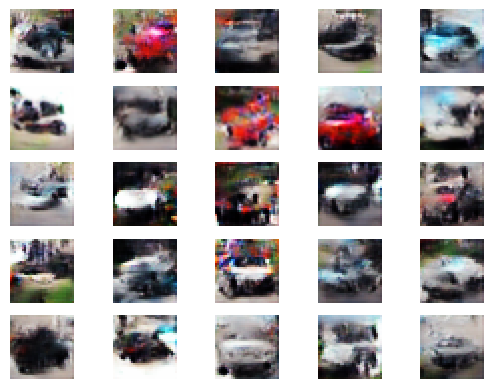

 20%|█▉        | 5999/30000 [10:09<37:45, 10.59it/s]  

6000 [D loss: 0.702416, acc.: 43.75%] [G loss: 0.714239]
1/1 [==============================] - 0s 18ms/step


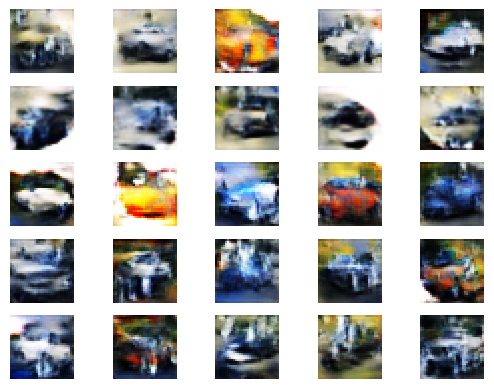

 22%|██▏       | 6499/30000 [11:00<38:06, 10.28it/s]  

6500 [D loss: 0.688902, acc.: 48.44%] [G loss: 0.700114]
1/1 [==============================] - 0s 19ms/step


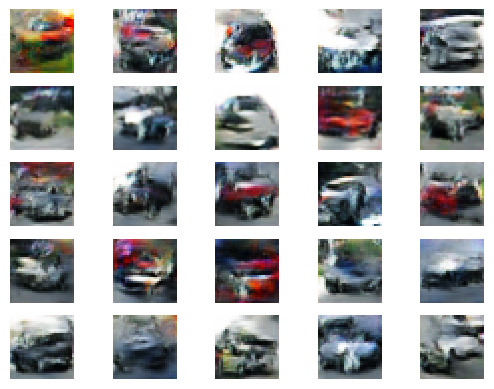

 23%|██▎       | 7000/30000 [11:51<37:01, 10.35it/s]  

7000 [D loss: 0.686724, acc.: 56.25%] [G loss: 0.694608]
1/1 [==============================] - 0s 18ms/step


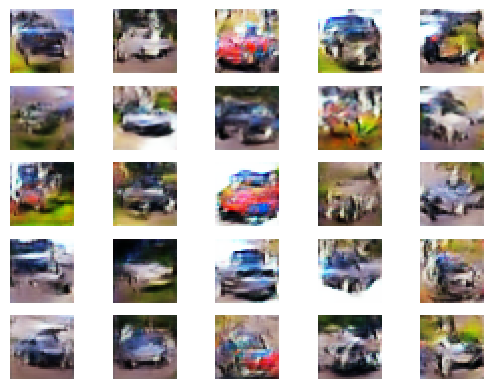

 25%|██▌       | 7500/30000 [12:43<37:47,  9.92it/s]  

7500 [D loss: 0.704019, acc.: 46.88%] [G loss: 0.724476]
1/1 [==============================] - 0s 19ms/step


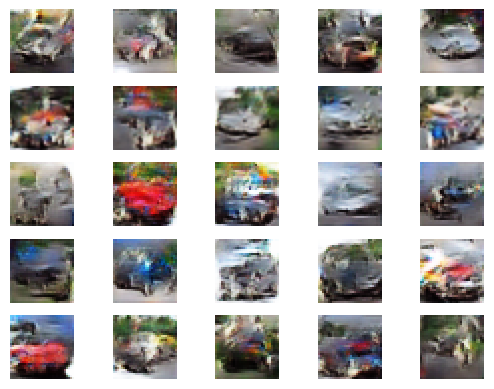

 27%|██▋       | 8000/30000 [13:33<37:33,  9.76it/s]  

8000 [D loss: 0.706415, acc.: 39.06%] [G loss: 0.702193]
1/1 [==============================] - 0s 20ms/step


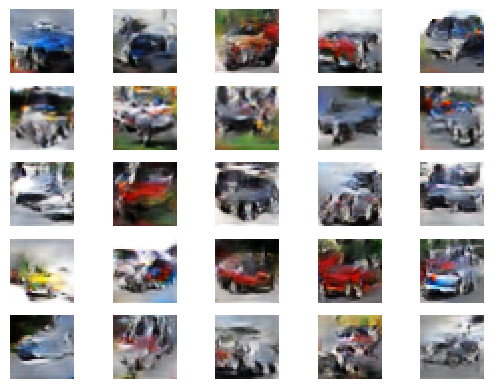

 28%|██▊       | 8500/30000 [14:24<34:07, 10.50it/s]  

8500 [D loss: 0.697411, acc.: 46.88%] [G loss: 0.717612]
1/1 [==============================] - 0s 17ms/step


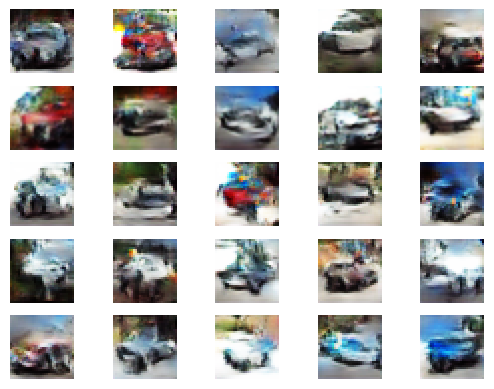

 30%|███       | 9000/30000 [15:16<35:05,  9.97it/s]  

9000 [D loss: 0.694260, acc.: 46.88%] [G loss: 0.697556]
1/1 [==============================] - 0s 18ms/step


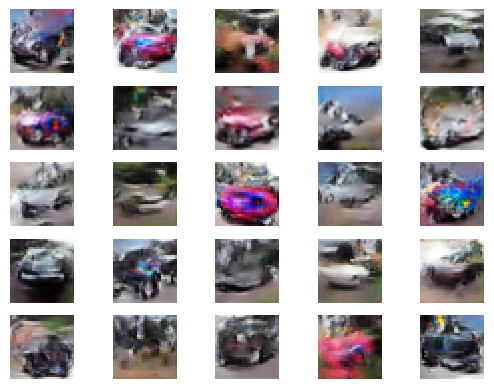

 32%|███▏      | 9500/30000 [16:07<33:00, 10.35it/s]  

9500 [D loss: 0.692518, acc.: 53.12%] [G loss: 0.730959]
1/1 [==============================] - 0s 18ms/step


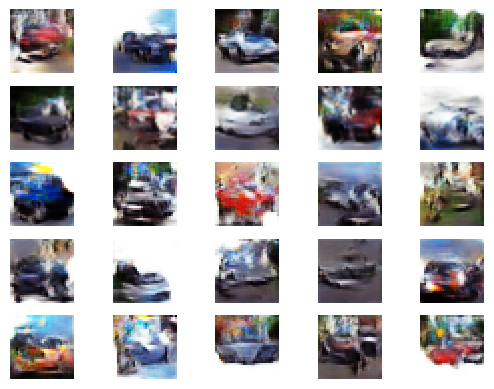

 33%|███▎      | 9999/30000 [16:58<32:40, 10.20it/s]  

10000 [D loss: 0.700107, acc.: 39.06%] [G loss: 0.720727]
1/1 [==============================] - 0s 19ms/step


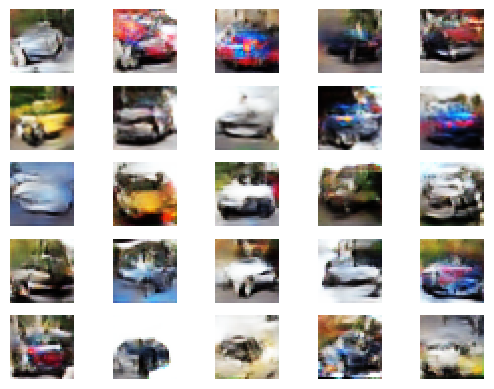

 35%|███▌      | 10500/30000 [17:49<33:25,  9.72it/s]  

10500 [D loss: 0.695654, acc.: 53.12%] [G loss: 0.727188]
1/1 [==============================] - 0s 20ms/step


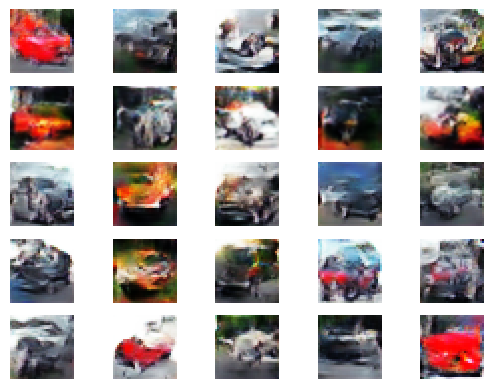

 37%|███▋      | 11000/30000 [18:40<31:35, 10.02it/s]  

11000 [D loss: 0.700556, acc.: 39.06%] [G loss: 0.740285]
1/1 [==============================] - 0s 20ms/step


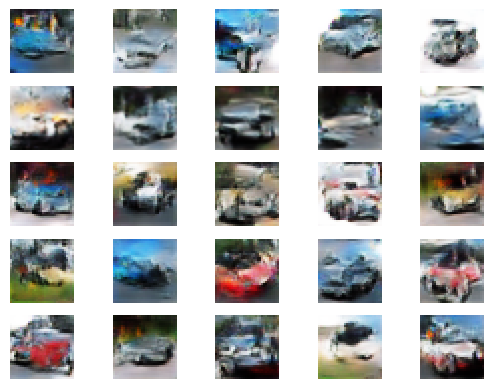

 38%|███▊      | 11500/30000 [19:32<29:39, 10.40it/s]  

11500 [D loss: 0.688433, acc.: 50.00%] [G loss: 0.701067]
1/1 [==============================] - 0s 20ms/step


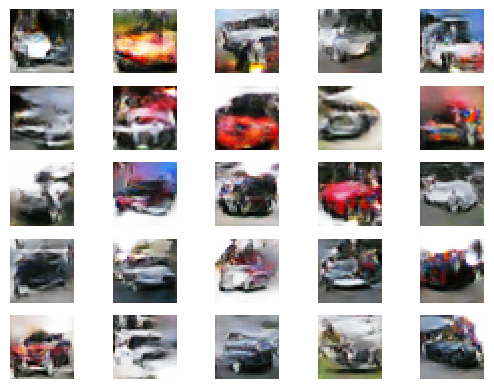

 40%|███▉      | 11999/30000 [20:23<28:26, 10.55it/s]  

12000 [D loss: 0.693836, acc.: 50.00%] [G loss: 0.667363]
1/1 [==============================] - 0s 18ms/step


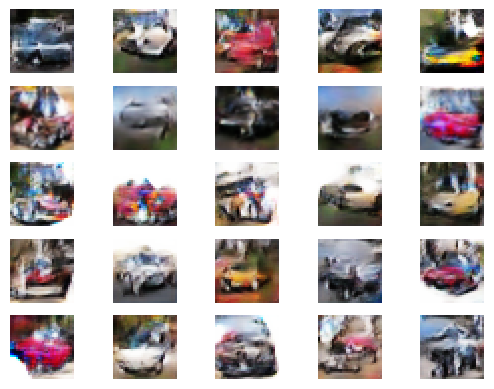

 42%|████▏     | 12500/30000 [21:15<28:20, 10.29it/s]  

12500 [D loss: 0.699974, acc.: 48.44%] [G loss: 0.712507]
1/1 [==============================] - 0s 18ms/step


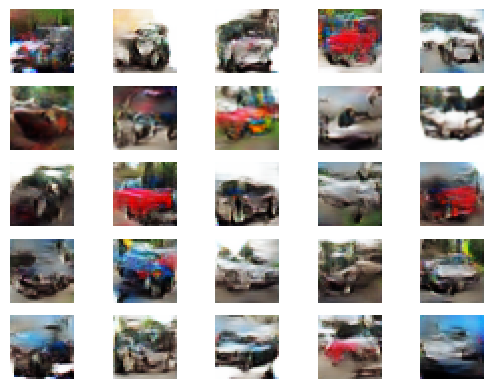

 43%|████▎     | 12999/30000 [22:06<28:16, 10.02it/s]  

13000 [D loss: 0.694559, acc.: 48.44%] [G loss: 0.659514]
1/1 [==============================] - 0s 20ms/step


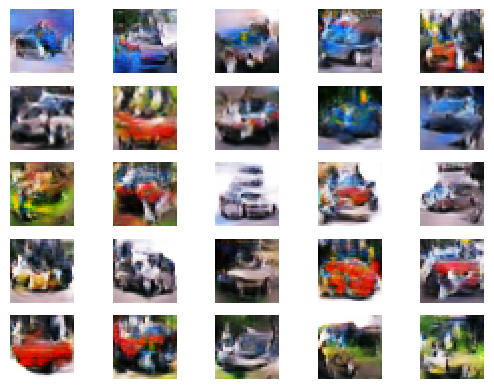

 45%|████▍     | 13499/30000 [22:57<28:18,  9.71it/s]  

13500 [D loss: 0.692571, acc.: 51.56%] [G loss: 0.733585]
1/1 [==============================] - 0s 20ms/step


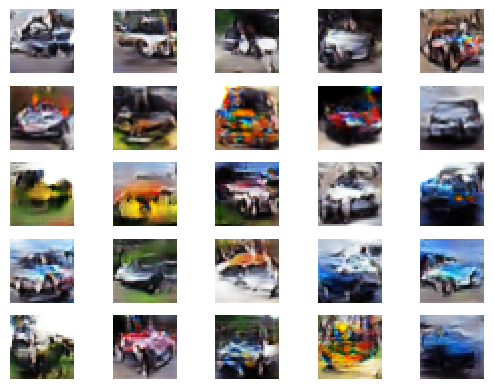

 47%|████▋     | 13999/30000 [23:48<25:44, 10.36it/s]  

14000 [D loss: 0.682087, acc.: 60.94%] [G loss: 0.717264]
1/1 [==============================] - 0s 17ms/step


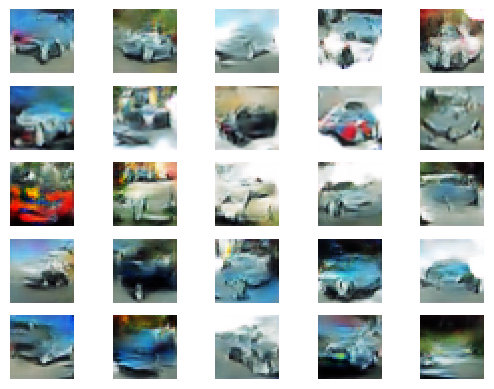

 47%|████▋     | 14237/30000 [24:13<27:07,  9.68it/s]  

In [ ]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=30000, batch_size=32, sample_interval=500)

## Adding Code to Save & Load Model Object

In [ ]:
from keras.models import load_model
import pickle
# Save the generator model
gan.generator.save('Car_generator_model.h5')

# Save the discriminator model
gan.discriminator.save('Car_discriminator_model.h5')

# If you have a combined model and want to save it as well
gan.combined.save('Car_combined_model.h5')

## Visualizing Output generated by Generator

In [19]:
def generate_images(generator, latent_dim, n_images=10):
    # Generate a batch of random noise vectors
    noise = np.random.normal(0, 1, (n_images, latent_dim))
    # Use the trained generator to generate images
    generated_images = generator.predict(noise)
    # Rescale the images to the range [0, 1]
    generated_images = 0.5 * generated_images + 0.5
    return generated_images


In [20]:
def plot_generated_images(images, n_cols=8):
    n_rows = (len(images) + n_cols - 1) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1, n_rows * 1))
    cnt = 0
    for i in range(n_rows):
        for j in range(n_cols):
            if cnt < len(images):
                axs[i,j].imshow(images[cnt])
                axs[i,j].axis('off')
                cnt += 1
            else:
                axs[i,j].axis('off')
    plt.show()


1/1 [==============================] - 0s 19ms/step


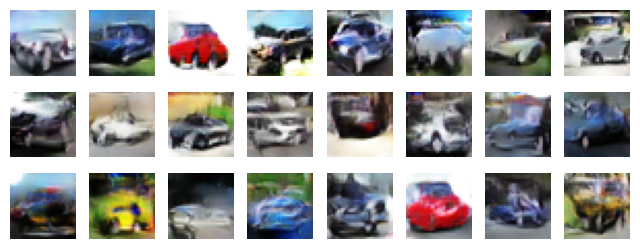

In [21]:
# Generate a set of images
generated_images = generate_images(gan.generator, gan.latent_dim, 24)
plot_generated_images(generated_images)


## Studying the effect of controlling the noise vector

To study the effect of controlling our noise vector. We generate a set images by changing the noise vector's distribution. 
Here, we try the following distributions. 

In [27]:
def generate_images_new(generator, latent_dim, noise, n_images=10):
    # Use the trained generator to generate images
    generated_images = generator.predict(noise)
    # Rescale the images to the range [0, 1]
    generated_images = 0.5 * generated_images + 0.5
    return generated_images

### Normal Distribution
The normal (Gaussian) distribution is a common choice for generating noise vectors in GANs due to its properties of symmetry and a tendency to produce values around a mean. This distribution often results in a diverse yet balanced set of generated images.


**Observations**: The generated images showcase a mix of features with variations that seem naturally occurring. This reflects the Gaussian distribution's characteristic of centering around a mean with a predictable deviation. We can see that the images contain variations in color, shape, and positioning, yet none seem to be extreme outliers, indicating the generator's ability to produce coherent and realistic images from the noise vector.


1/1 [==============================] - 0s 19ms/step


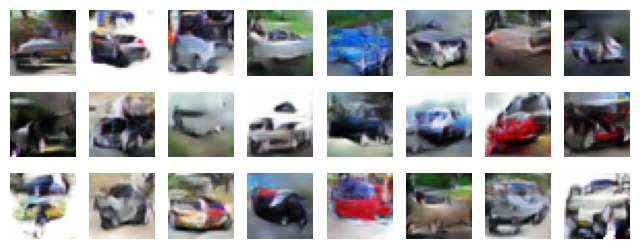

In [40]:
# Generate a noise vector on Normal distribution
noise = np.random.normal(0, 1, (24, gan.latent_dim))

generated_images = generate_images_new(gan.generator, gan.latent_dim, noise, 24)
plot_generated_images(generated_images)

### Uniform Distribution
The uniform distribution generates noise with equal probability across the given range. This distribution is useful for exploring the latent space without any prior bias towards certain features.


**Observations**: The images exhibit a broad variety of features, reflecting the unbiased nature of the uniform distribution. However, the lack of focus can sometimes result in less coherence within the generated images.


1/1 [==============================] - 0s 19ms/step


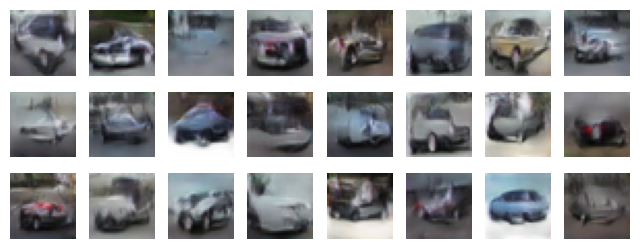

In [41]:
noise = np.random.uniform(-1, 1, (24, gan.latent_dim))
generated_images = generate_images_new(gan.generator, gan.latent_dim, noise, 24)
plot_generated_images(generated_images)

### Truncated Normal Distribution
The truncated normal distribution, a bound version of the normal distribution, avoids extreme values in the noise vector. This can prevent the generation of images with unrealistic or exaggerated features.


**Observations**: Compared to the standard normal distribution, the truncation results in a more concentrated exploration of the latent space, potentially leading to more consistent but less varied images.


1/1 [==============================] - 0s 20ms/step


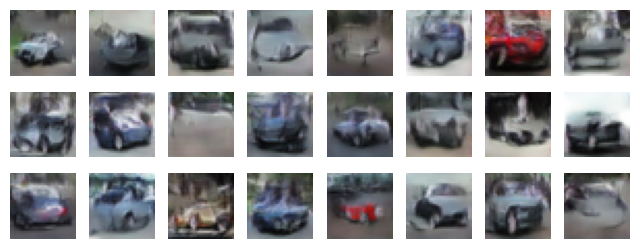

In [42]:
from scipy.stats import truncnorm

def truncated_normal(size, threshold=1):
    return truncnorm.rvs(-threshold, threshold, size=size)

noise = truncated_normal((24, gan.latent_dim))
generated_images_truncated = generate_images_new(gan.generator, gan.latent_dim, noise, 24)
plot_generated_images(generated_images_truncated)

### Logistic Distribution
The logistic distribution introduces noise with heavier tails than a normal distribution, which can lead to the generation of images with more pronounced variations within the learned feature set.


**Observations**: The generated images tend to show more extreme variations, with some features being more exaggerated. This can be beneficial for testing the limits of the model's generative capabilities.


1/1 [==============================] - 0s 18ms/step


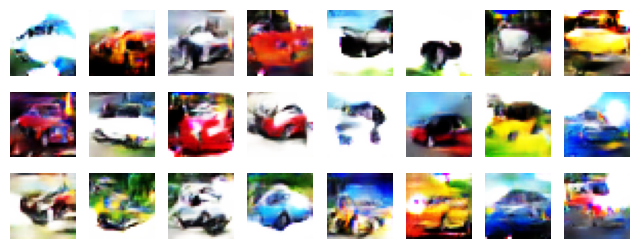

In [43]:
noise = np.random.logistic(0, 1, (24, gan.latent_dim))
generated_images_truncated = generate_images_new(gan.generator, gan.latent_dim, noise, 24)
plot_generated_images(generated_images_truncated)


### Laplace Distribution
The Laplace distribution is characterized by its sharp peak and heavy tails, leading to a higher likelihood of sampling values near the mean while still allowing for occasional extreme variations.

**Observations**: The generated images often present a mix of typical and atypical features, offering a balance between variety and realism. This distribution can be particularly useful when a subtle emphasis on central features is desired.


1/1 [==============================] - 0s 20ms/step


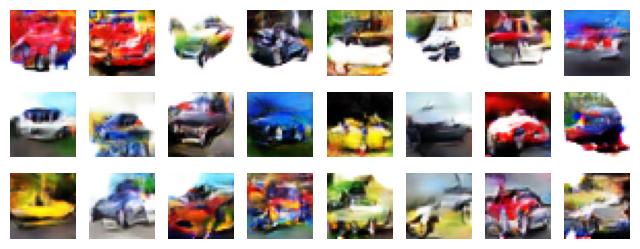

In [44]:
# Laplace Distribution
noise = np.random.laplace(0, 1, (24, gan.latent_dim))
generated_images_truncated = generate_images_new(gan.generator, gan.latent_dim, noise, 24)
plot_generated_images(generated_images_truncated)

## Analysis

In each case, the choice of distribution shapes the latent space in distinct ways, influencing the diversity and realism of the generated images. By analyzing these results, we can fine-tune the noise distribution to guide the GAN towards generating images with desired characteristics.



## Optional : Zipping together all images for creating a video/gif

In [ ]:
import zipfile
import os

def zip_specific_files(directory, zip_name, start_epoch, end_epoch, step, max_files=100):
    # Initialize a counter for the number of files added
    file_count = 0
    
    # Create a ZipFile object in write mode
    with zipfile.ZipFile(os.path.join(directory, zip_name), 'w') as zipf:
        for epoch in range(start_epoch, end_epoch + 1, step):
            # Construct the filename based on the epoch
            file_name = f"Car_Image_Epoch{epoch}.png"
            file_path = os.path.join(directory, file_name)
            
            # Check if the file exists
            if os.path.isfile(file_path):
                # Add the file to the zip
                zipf.write(file_path, arcname=file_name)
                file_count += 1
                

    if file_count > 0:
        print(f"Zip file created with {file_count} files at {os.path.join(directory, zip_name)}")
    else:
        print("No files were added to the zip.")

# Example usage
directory = '/kaggle/working'  # The directory containing the files
zip_name = 'Car_selected_images2.zip'  # Name of the zip file to create
start_epoch = 200  # Starting epoch number
end_epoch = 29800  # Ending epoch number
step = 200  # Step between epochs

zip_specific_files(directory, zip_name, start_epoch, end_epoch, step)


## Optional : Combining all the images to create a gif

In [ ]:
import imageio
import os

def create_gif_from_images(directory, output_filename, start_epoch, end_epoch, step):
    images = []
    for epoch in range(start_epoch, end_epoch + 1, step):
        filename = f"Car_Image_Epoch{epoch}.png"
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            images.append(imageio.imread(filepath))
    imageio.mimsave(os.path.join(directory, output_filename), images, fps=10) # Adjust fps as needed

# Example usage
directory = '/kaggle/working'
create_gif_from_images(directory, 'Car_gan_output.gif', 200, 29800, 200)

# Optional : Combining all Images to create a video

In [ ]:
import cv2
import os

def create_video_from_images(directory, output_filename, start_epoch, end_epoch, step, fps=30, frame_size=(640, 480)):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Define the codec and create VideoWriter object
    out = cv2.VideoWriter(os.path.join(directory, output_filename), fourcc, fps, frame_size)
    
    for epoch in range(start_epoch, end_epoch + 1, step):
        filename = f"Car_Image_Epoch{epoch}.png"
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            img = cv2.imread(filepath)
            img_resized = cv2.resize(img, frame_size)  # Resize the image to match the frame size
            out.write(img_resized)
    out.release()

# Example usage
directory = '/kaggle/working'
frame_size = (640, 480) # Set this to the size of your images or desired video resolution
create_video_from_images(directory, 'Car_gan_output.mp4', 200, 29800, 200, fps=10, frame_size=frame_size)
